In [1]:
# Defining a polynomial ring called RQ over the rationals in two variables, z, w.
RQ.<z,w> = QQ[]

In [2]:
# Input polynomial.
f = (z^2)*(w^6) + 2*(z^3)*(w^5) - 1
d = f.degree(w)

In [3]:
# Differentiating f with respect to w.
dfdw = diff(f,w)
dfdw

10*z^3*w^4 + 6*z^2*w^5

In [4]:
# Computing the resultant of dfdw with respect to w. This will be a polynomial in one variable, z.
# The roots of this polynomial encode the branch locus for which the algebraic curve defined by f has a branch cut.
branchpolynomial = f.resultant(dfdw,w)
branchpolynomial

-200000*z^20 - 46656*z^12

In [5]:
# We wish to compute the complex-valued roots, so we define the ring which branchpolynomial lies in as a complex valued 
# polynomial. Since computers can't really work with transcendentals, we use 53 bits of precision for the numbers.
#
# The variable z is in apostrophes to indicate that it is the same variable as above.
CCz = ComplexField(53)['z']

In [6]:
# Computing the roots.
branchlocus = CCz(branchpolynomial).roots(multiplicities=false)

In [7]:
# Seperating the real and imaginary parts into x-y-coordinates for use in plotting.
branchlocusXY = [(x.real_part(),x.imag_part()) for x in branchlocus]

In [8]:
# Importing necessary packages. Namely, Voronoi and integration.
#
# Note: it is unclear to me whether it is important that Nils imports this here specifically rather than at the beginning 
#       of the code.
#
from scipy.spatial import Voronoi, voronoi_plot_2d
import scipy.integrate

In [9]:
# Defining the boundary points for the Voronoi diagram. In the future, it may be useful to try using a circle (or rather 
# an approximation to one). The below code will ensure that our branch points are actually contained in the interior of 
# the box, but there may be better designs for the box.

# First try on box.
maxx = 2*max(x for x,y in branchlocus)
minx = 2*min(x for x,y in branchlocus)
maxy = 2*max(y for x,y in branchlocus)
miny = 2*min(y for x,y in branchlocus)

# If some of the coordinates are zero, then our points will lie on the boundary of the box. We don't want this.
# There is really only one case. If the max is zero, we know the min is negative, so we can just flip the sign. A similar 
# argument works for if the min is zero, we just flip signs. Then we can do it for the y as well.
if abs(maxx) < 10^(-5):
    maxx = -minx
if abs(minx) < 10^(-5):
    minx = -maxx
if abs(maxy) < 10^(-5):
    maxy = -miny
if abs(miny) < 10^(-5):
    miny = -maxy

# Also, they are actually supposed to form a box!! So if one of the intervals collapses to a single point, we have to fix 
# that.
#
# In our situation, we will always have at least two points- Otherwise, our algebraic curve has genus zero. This is not
# an interseting case for us. This means that only one of the intervals could be trivial. For instance, if all of the 
# roots are real, they all lie on the x-axis.
#
# To fix this, we just make the interval the same as the one which is not trivial. Shifted accordingly so that the points 
# are centered at it.
#
# There may be a better way to do this, but I'm not sure what that is. This is just a temporary fix anyways.
if (abs(minx - maxx) < 10^(-5)):
    minx = branchlocus[0][0] - (abs(maxy) + abs(miny))/2
    maxx = branchlocus[0][0] + (abs(maxy) + abs(miny))/2

if (abs(miny - maxy) < 10^(-5)):
    miny = branchlocus[0][1] - (abs(maxx) + abs(minx))/2
    maxy = branchlocus[0][1] + (abs(maxx) + abs(minx))/2

# Now, with all of our points we can form our Voronoi diagram.
B = branchlocusXY + [(x,y) for x in [minx,maxx] for y in [miny,maxy]]
vor = Voronoi(B)

In [10]:
# Plotting the diagram. According to Nils, some problems with the matlabplot installation means that I must save figures 
# seperately.
t=voronoi_plot_2d(vor)
t.savefig('figure.png')

In [11]:
# For each vertex z0 of the Voronoi diagram, we associate d points (where d is the degree of f in w), which are the roots 
# of f(z0,w) in w.
CC = ComplexField(53)
CCw = CC['w']

# Each vertex will be interpreted as a complex number.
vertices = [CC(x0,y0) for x0,y0 in vor.vertices]
# We can plug in these values and solve the resulting polynomials.
wvalues = [f(z0,CCw.0).roots(multiplicities=false) for z0 in vertices]
# n is the number of vertices.
n = len(vertices)

In [12]:
# We care only about the regions associated with the branchlocus points, since the regions around infinity can be computed
# differently.
monodromy_basis = [vor.regions[vor.point_region[i]] for i in range(len(branchlocus))]
# Note: It may be worth reorienting the order of the cycles to always
#       be counter-clockwise.


# Below is a relic of a misunderstanding.
#
# We want the points of the voronoi diagram to be ordered with respect
# to argument when interpreted as complex points.
#indexswap = [y for (x,y) in sorted(zip(vertices,range(len(vertices))),
#             key = lambda tuple: tuple[0].argument())]
#print indexswap
# This changes the position of the vertices.
#vor.vertices = [vor.vertices[i] for i in indexswap]
# This changes all of the edges in the monodromy basis...
#monodromy_basis = [[indexswap.index(i) for i in x] for x in monodromy_basis]
#print "New Monodromy basis: \n", monodromy_basis
# Finally, sorts the complex numbers.
#vertices.sort(key=sage.rings.complex_number.ComplexNumber.argument)

In [13]:
# Computing the edgeset of the Voronoi diagram.
# Frozensets are used here because we don't distinguish between (1,2) and (2,1) being different edges.
edges1 = set()
for c in monodromy_basis:
    for j in range(len(c)-1):
        edges1.add(frozenset((c[j],c[j+1])))
    edges1.add(frozenset((c[0],c[-1])))

# Convert this back to a list, then sort. I use this later to easily compute the permutations associated with an edge
# but perhaps we don't need to do this?
edges = []
for e in edges1:
    i0, i1 = e
    edges = edges + [(i0,i1)]
edges.sort()

print "Voronoi diagram edges:", edges

Voronoi diagram edges: [(0, 1), (0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (2, 7), (3, 6), (4, 5), (6, 7), (8, 9), (8, 11), (8, 15), (9, 10), (9, 12), (10, 4), (10, 11), (11, 5), (12, 13), (12, 15), (13, 6), (13, 14), (14, 7), (14, 15)]


In [14]:
# Main Procedure to compute the graph upstairs.
# First, form the vertex set.
vertexset = []
for i in range(len(vertices)):
    for j in range(len(wvalues[i])):
        vertexset = vertexset + [(i,j)]

edgeset = []
# Now, forming the edge set. Every edge in the downstairs graph will have d edges in the lifted graph, where d is the 
# degree of f in w. As such, we loop over all of the edges to determine what these are.
for e in edges:
    # Taking the two indices out of the edges, as well as the complex values of the vertices for use in integration.
    i0, i1 = e
    z0, z1 = vertices[i0], vertices[i1]
    # Defining the complex field which we are working under.
    CCtw.<tC,wC> = CC[]
    # Nils does some ode solver business here. This is where we 'move along the direction field' using df/dw to get to the
    # next root.
    ft = f(z0+tC*(z1-z0),wC)
    G = -derivative(ft,tC)/derivative(ft,wC)
    ode_solver = scipy.integrate.ode(lambda t,y: [complex(G(t,y[0]))])
    ode_solver.set_integrator("zvode",rtol=10^(-10), order = 7, method = 
                              "adams")
    # Determining where the w0s get sent.
    for i in range(len(wvalues[i0])):
        # This is approximately the value which w0 gets sent to.
        ode_solver.set_initial_value([wvalues[i0][i]],0)
        w1 = CC(ode_solver.integrate(1)[0])
        # Checking over the w1values to check which one it is. Later, it will likely be necessary to use some additional
        # theory to check this, like some series expansions and things. For now I just use a ball of small radius.
        for j in range(len(wvalues[i1])):
            if abs(w1 - wvalues[i1][j]) < 10^(-5):
                # If it is close to this particular value, then it adds an edge between the appropriate vertices.
                edgeset = edgeset + [[(i0,i),(i1,j)]]
        

In [15]:
print "\n The vertex set is: \n", vertexset
print "\n The edge set is: \n", edgeset


 The vertex set is: 
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5)]

 The edge set is: 
[[(0, 0), (1, 0)], [(0, 1), (1, 1)], [(0, 2), (1, 2)], [(0, 3), (1, 3)], [(0, 4), (1, 4)], [(0, 5), (1, 5)], [(0, 0), (3, 1)], [(0, 1), (3, 0)], [(0, 2),

In [16]:
# My edge set will always be of the form
# [( [i,0], [j,p] ), ... , ( [i,d-1], [j,q]), ( [k,0], [l,r] ) ... ].
# Because I sorted it that way. This makes it pretty easy to access permutations because I can just take the second 
# coordinate of the second vertex in my edge.
#
# NOTE: If I drop the sorting which I do earlier on, this will fail.
#
Sn = SymmetricGroup([0..d])

# Computing the set of permutations associated with each edge.
PermSet = []
for n in range(len(edges)):
    tempPerm = []
    for i in [0..d-1]:
        tempPerm = tempPerm + [edgeset[d*n+i][1][1]]
    PermSet = PermSet + [Sn(tempPerm)]

In [17]:
zip(edges, PermSet)

[((0, 1), ()),
 ((0, 3), (0,1)(2,3)),
 ((0, 4), (4,5)),
 ((1, 2), (0,1)(2,3,5,4)),
 ((1, 5), (0,1,3)(4,5)),
 ((2, 3), (4,5)),
 ((2, 7), ()),
 ((3, 6), ()),
 ((4, 5), (0,1)),
 ((6, 7), ()),
 ((8, 9), (0,1)),
 ((8, 11), ()),
 ((8, 15), (0,2,3,1)(4,5)),
 ((9, 10), ()),
 ((9, 12), (2,3)(4,5)),
 ((10, 4), (1,2)(3,4)),
 ((10, 11), ()),
 ((11, 5), (1,2)(3,4)),
 ((12, 13), (0,1)),
 ((12, 15), ()),
 ((13, 6), (1,2)(3,4)),
 ((13, 14), (4,5)),
 ((14, 7), (1,2)(3,4)),
 ((14, 15), (0,1)(2,4,5))]

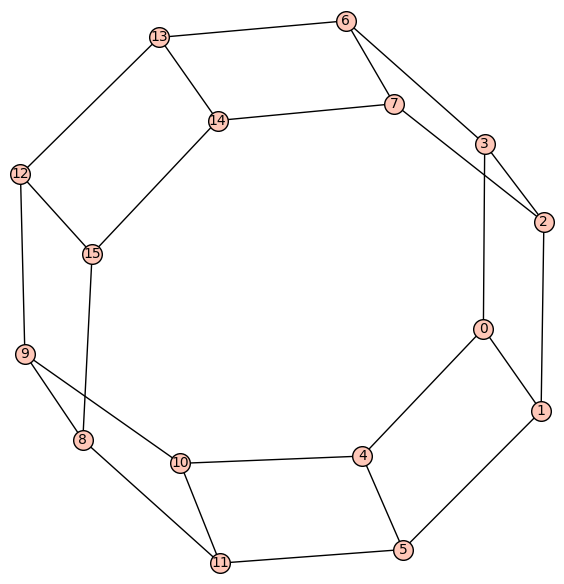

In [18]:
downstgraph = Graph(edges)
downstgraph.plot()

In [19]:
# Computing the set of generators of the monodromy group.

cycbasisd = downstgraph.cycle_basis()

# Forming this as a set to keep the information of each cycle. The i-th permutation corresponds to the i-th cycle, I want
# to keep this information.
monodromygens = []
perm = Sn(())
for c in cycbasisd:
    for i in range(len(c)-1):
        # My permutations are 'directed'- they depend on the direction which you're moving. Since my PermSet was 
        # constructed so that the permutations only correspond to 'lower going to higher', I add this conditional checking
        # which case I'm in. If I have an edge like (5,3), it takes the inverse instead.
        if (c[i] < c[i+1]):
            perm = perm*PermSet[c[i]]
        else:
            perm = perm*(PermSet[c[i]])^(-1)
    if (c[-1] < c[0]):
        perm = perm*PermSet[c[-1]]
    else:
        perm = perm*(PermSet[c[-1]])^(-1)
    monodromygens = monodromygens + [perm]

print monodromygens

[(1,3,2), (0,3,2,1), (0,1,2), (0,1,3,2)(4,5), (0,1,5,3), (1,3,2)(4,5), (0,4,5,3,1,2), (0,5,2)(1,4,3), (0,5,2)(1,4,3)]


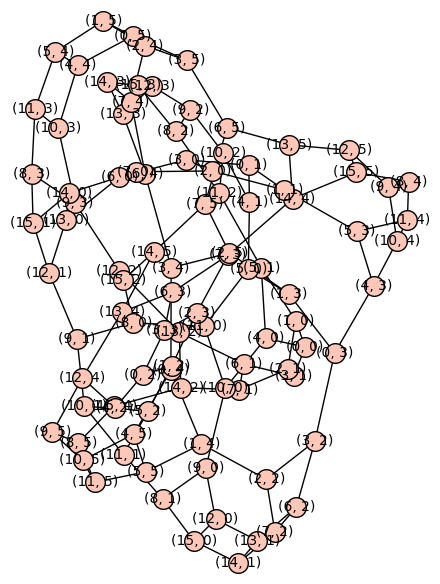

In [20]:
upstgraph = Graph(edgeset)
upstgraph.plot()

In [21]:
cycbasisu = upstgraph.cycle_basis()

In [22]:
# Computing the Gram matrix.
cn = len(cycbasisu)
# Forming a list of lists of zeroes. Later this will be converted into a matrix.
intersectionprod = [[0 for c in cycbasisu] for c in cycbasisu]
# This loop will start at the entry (0,1), and proceed along the row up til (0,cn-1). Then it will go to entry (1,2), and 
# proceed along the row, etc.
for i in range(cn-1):
    for j in range(cn-1-i):
        # Initializing the intersection product value.
        intsum = 0
        # Intersection of the edges
        intsec = set(cycbasisu[i]).intersection(set(cycbasisu[j+i+1]))
        # First if statement, checking if the intersection is non-empty. If it isn't, then we'll just skip all of the work
        if intsec != set():
            # For each vertex in the intersection:
            for v in intsec:
                # Get indices of the vertex in the cycles.
                i0 = cycbasisu[i].index(v)
                i1 = cycbasisu[j+i+1].index(v)
                # Get the complex value of the vertex v.
                vd = vertices[cycbasisu[i][i0][0]]
                # Get the two adjacent vertices to v in each cycle. There is some modular arithmetic here for if v is the
                # last vertex in the cycle, so that the next adjacent vertex is the first element in the list.
                # Also, I just skip straight to the downstairs vertices since that's what we care about.
                vds = [cycbasisu[i][i0-1][0],
                       cycbasisu[i][mod(i0+1,len(cycbasisu[i]))][0],
                       cycbasisu[j+i+1][i1-1][0],
                       cycbasisu[j+i+1][mod(i1+1,len(cycbasisu[j+i+1]))][0]]
                # The angles of the vectors.
                cds = [(vertices[vds[0]] - vd).argument(),
                      (vertices[vds[1]] - vd).argument(),
                      (vertices[vds[2]] - vd).argument(),
                      (vertices[vds[3]] - vd).argument()]
                # Above, a_in = cds[0], a_out = cds[1]
                #        b_in = cds[2], b_out = cds[3].
                # Lots of cases.
                if cds[0] < cds[1]:
                    # 1
                    if (cds[0] < cds[2] < cds[1]):
                        intsum = intsum + 1/2
                    # 2
                    elif (cds[2] < cds[0]) or (cds[1] < cds[2]):
                        intsum = intsum - 1/2
                    # 3
                    elif (cds[0] < cds[3] < cds[1]):
                        intsum = intsum - 1/2
                    # 4
                    elif (cds[3] < cds[0]) or (cds[1] < cds[3]):
                        intsum = intsum + 1/2
                else:
                    assert(cds[1] < cds[0])
                    # 5
                    if (cds[1] < cds[3] < cds[0]):
                        intsum = intsum + 1/2
                    # 6
                    elif (cds[3] < cds[1]) or (cds[0] < cds[3]):
                        intsum = intsum - 1/2
                    # 7
                    elif (cds[1] < cds[2] < cds[0]):
                        intsum = intsum - 1/2
                    # 8
                    elif (cds[2] < cds[1]) or (cds[0] < cds[2]):
                        intsum = intsum + 1/2
        intersectionprod[i][j+i+1] = intsum
        # Skew Symmetry
        intersectionprod[j+i+1][i] = -intsum

Gmatrix = Matrix(intersectionprod)

In [23]:
print Gmatrix

49 x 49 dense matrix over Rational Field


In [24]:
# Checking the stuff. The rank should be 2*g where g is the genus.
V = ZZ^cn
W = Gmatrix.kernel()
M = V/W
b = matrix([v.lift() for v in M.gens()])
Mrank = b.rank()
print Mrank

6


In [25]:
# Second checking stuff thing. The determinant should be 1, unless the genus is zero in which case it'll probably
# return an error.
newgram = b*Gmatrix*(b.transpose())
print newgram
newgram.determinant()

[ 0  0  0  1  0  1]
[ 0  0  0  1  0  0]
[ 0  0  0  1  1  0]
[-1 -1 -1  0 -1  0]
[ 0  0 -1  1  0  0]
[-1  0  0  0  0  0]


1

In [26]:
# Input:   mat   - A matrix.
#        i,j,k,l - Integers with i <= j, k <= l.
#
# Output: A block of matrix mat- the i-jth rows, and k-lth columns.
#
def takeblock(mat,i,j,k,l):
    rowind = [i+p for p in range(j-i+1)]
    colind = [k+p for p in range(l-k+1)]
    return matrix(ZZ, [[mat[p][q] for q in colind] for p in rowind])

# Input: mat - A matrix.
#        i   - An integer.
#        rc  - A string.
#
# Output: Adds i rows or columns of zeroes to mat, from the top or bottom.
#
def addzeroes(mat,i,rc):
    if i == 0:
        return mat
    elif (rc == "rowt"):
        return matrix([[0 for j in range(i)]+list(mat.transpose()[k]) for k in range(mat.ncols())]).transpose()
    elif (rc == "coll"):
        return matrix([[0 for j in range(i)]+list(mat[k]) for k in range(mat.nrows())])
    elif (rc == "rowb"):
        return matrix([list(mat.transpose()[k])+[0 for j in range(i)] for k in range(mat.ncols())]).transpose()
    elif (rc == "colr"):
        return matrix([list(mat[k])+[0 for j in range(i)] for k in range(mat.nrows())])
    else:
        print "Error, string should be rowt, rowb, coll or colr."
        return

# Input: mat1, mat2 - Matrices with the same number of columns.
#
# Output: Returns a matrix ( mat1 )
#                          ( mat2 ).
#
def conjoinmat(mat1, mat2):
    return matrix([mat1[i] for i in range(mat1.nrows())] + [mat2[i] for i in range(mat2.nrows())])

In [27]:
# Input: A skew-symmetric square matrix M.
#
# Output: A matrix P such that PMP^T = J, the standard symplectic basis.
#
def FrobAlg(mat):
    matrank = mat.rank()
    P = matrix.identity(mat.nrows())
    currmat = mat
    for i in range(matrank/2):
        currdim = currmat.nrows()
        # In A.smith_form(), we get RAC = D.
        # The output is [D,R,C].
        # To form M, take first row of R.
        e1 = currmat.smith_form()[1][0]
        # The first column of C.
        e2 = currmat.smith_form()[2].column(0)
        # Form M.
        M = matrix([e1,e2])
        # Take the last n-2 rows of Q in PNQ = M.
        # Since Smith Normal form gives P^(-1) M Q^(-1) = N,
        # we take the inverses.
        Mtil = conjoinmat(M, takeblock(M.smith_form()[2]^(-1),2,currdim-1,0,currdim-1))
        # B as in Frobenius proof.
        B = Mtil*currmat*(Mtil.transpose())
        # R as in Frobenius proof.
        R = takeblock(B,0,1,2,currdim-1)
        R = matrix([[0,1],[-1,0]])*R
        # X as in Frobenius proof.
        X = addzeroes(addzeroes(R,2,"coll"),currdim-2,"rowb").transpose() + matrix.identity(currdim)
        # P, the desired output. This matrix will be smol. So we make it big.
        Pprime = X*Mtil
        if (i != 0):
            Pprime = (addzeroes(addzeroes(Pprime,2*i,"coll"),2*i,"rowt") + 
                      addzeroes(addzeroes(matrix.identity(2*i),currdim,"colr"),currdim,"rowb"))
        P = Pprime*P
        # Change the matrix to A_1 as in Frobenius proof.
        currmat = takeblock(X*B*(X.transpose()),2,currdim-1,2,currdim-1)
    return P

Pf = FrobAlg(Gmatrix)
print Pf*Gmatrix*(Pf.transpose())

# note, referencing smith form twice is bad

49 x 49 dense matrix over Rational Field


In [28]:
print Pf

49 x 49 dense matrix over Rational Field


In [29]:
# We want 2g cycles. 
# a_i = \sum_{j=1}^r Pf[i][j] c_j
# b_i = \sum_{j=1}^r Pf[i+g][j] c_j
# i = 1..g

# 

